In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, re

In [12]:
def loadRuns(path="../"):
    runs = {}

    run_RE = re.compile("slurm-([0-9]+)(.out|)$")
    bs_RE = re.compile("Train Buffer Size: 0, training batch size: ([0-9]+)")
    ranks_RE = re.compile("ranks [0-9]+ ([0-9]+)")
    lrscale_RE = re.compile("lrScaling ([a-zA-Z0-9]+)")
    lr_RE = re.compile("Skaling learning rate from ([0-9.]+) to ([0-9.]+) due to bs factor ([0-9.]+)")

    for fn in os.listdir(path):
        m = run_RE.match(fn)
        if not m:
            continue

        i = int(m[1])
        if i in runs:
            run = runs[i]
        else:
            run = {"i": i}
        
        found = 0
        if m[2] == ".out":
            with open(os.path.join(path, fn)) as f:
                lines = f.readlines()

            ranks = 0
            for l in lines:
                m = bs_RE.match(l)
                if m and not "bs" in run:
                    run["bs"] = int(m[1])
                    found += 1
                    
                m = ranks_RE.match(l)
                if m:
                    ranks += 1
            
                m = lrscale_RE.match(l)
                if m and not "lrscale" in run:
                    run["lrscale"] = m[1]
                    found += 1
                    
                m = lr_RE.match(l)
                if m and not "lr" in run:
                    run["lr"] = m[1]
                    run["lrscaled"] = m[2]
                    run["lrfactor"] = m[3]
                    found += 1
                    
            if found < 3:
                raise RuntimeError("meta data missign from .out file")
            
            if ranks == 0:
                raise RuntimeError("No ranks in run {}".format(fn))
            run["ranks"] = ranks
            
            runs[i] = run
    return runs

In [17]:
path="/bigdata/hplsim/scratch/kelling//oldBSruns/"
path="/bigdata/hplsim/scratch/kelling//fixedBSruns/"
path="/bigdata/hplsim/scratch/kelling//scaledlrRuns/"

runs = loadRuns(path)
runs

{6917424: {'i': 6917424,
  'lrscale': 'linear',
  'lr': '0.001',
  'lrscaled': '0.004',
  'lrfactor': '4.0',
  'bs': 8,
  'ranks': 1},
 6917423: {'i': 6917423,
  'lrscale': 'linear',
  'lr': '0.001',
  'lrscaled': '0.016',
  'lrfactor': '16.0',
  'bs': 8,
  'ranks': 4},
 6919037: {'i': 6919037,
  'lrscale': 'lin',
  'lr': '0.001',
  'lrscaled': '0.008',
  'lrfactor': '8.0',
  'bs': 16,
  'ranks': 1},
 6919036: {'i': 6919036,
  'lrscale': 'lin',
  'lr': '0.001',
  'lrscaled': '0.01',
  'lrfactor': '10.0',
  'bs': 20,
  'ranks': 1},
 6918921: {'i': 6918921,
  'lrscale': 'lin',
  'lr': '0.001',
  'lrscaled': '0.001',
  'lrfactor': '1.0',
  'bs': 2,
  'ranks': 1},
 6919038: {'i': 6919038,
  'lrscale': 'lin',
  'lr': '0.001',
  'lrscaled': '0.004',
  'lrfactor': '4.0',
  'bs': 8,
  'ranks': 1},
 6917428: {'i': 6917428,
  'lrscale': 'sqrt',
  'lr': '0.001',
  'lrscaled': '0.002',
  'lrfactor': '4.0',
  'bs': 8,
  'ranks': 1},
 6917425: {'i': 6917425,
  'lrscale': 'linear',
  'lr': '0.001',
 

In [18]:
def plotLosses(col, runs=runs, title=None):
    for r in runs.values():
        i = r["i"]
        if not "dat" in r:
            r["dat"] = np.loadtxt(f"{path}/slurm-{i}/loss_0.dat")
        dat = r["dat"]
        #print(i, dat.shape)
        if "lrscale" in r:
            lrscale = r["lrscale"]
        else:
            lrscale = "1"
        linestyle = "-"
        if lrscale == "sqrt":
            linestyle = ":"
        if "lr" in r:
            lr = r["lr"]
            lrscaled = r["lrscaled"]
        else:
            lr = "nan"
            lrscaled = "nan"
        plt.plot(dat[:, 0], dat[:, col], label=("{}: r{} bs{} lr{}->{}".format(i, r["ranks"], r["bs"], lr, lrscaled)),
                ls=linestyle)
    if title is None:
        plt.title(f"col {col}")
    else:
        plt.title(title)
    #plt.ylim((0,10))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

(0.0, 20.0)

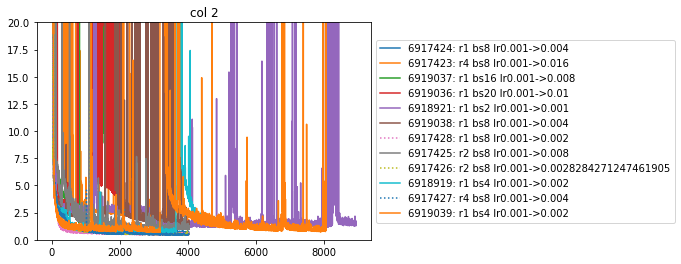

In [19]:
plotLosses(2)
plt.ylim((0,20))

(0.0, 1.0)

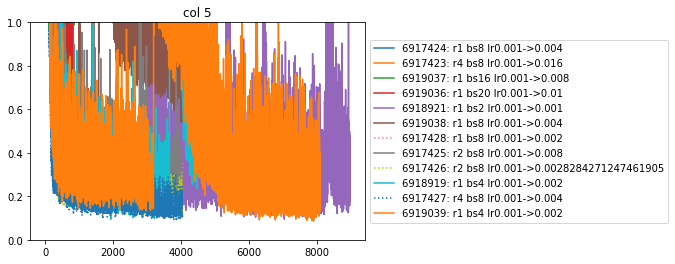

In [20]:
plotLosses(5)
plt.ylim((0,1))

In [7]:
for r in runs.values():
    dat = r["dat"]
    print(r["i"], r["ranks"], r["bs"], np.mean(dat[10:,1]))

6919037 1 16 5173.666500994036
6919036 1 20 6439.775236200895
6918921 1 2 4820.544124218052
6919038 1 8 2675.9196229223517
6918919 1 4 9478.852022867195
6919039 1 4 1397.7706603890472
